# Simulations on Real Data from Fairhaven/New Bedford Deployment

In [4]:
# Imports
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib import cm
from sklearn import mixture
from IPython.display import display
from scipy.stats import multivariate_normal
import numpy as np
import scipy as sp
import math
import os
import GPy as GPy
import dubins
import time
from itertools import chain
import ipp_library

# necessary imports
import pandas as pd
from matplotlib.image import NonUniformImage
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import seaborn as sns
from descartes import PolygonPatch
from shapely.geometry import LineString
from scipy.optimize import curve_fit
# import sensor_plotting as sp

%matplotlib inline
%pylab inline

pd.set_option('display.max_columns',None)
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 15

Populating the interactive namespace from numpy and matplotlib


In [5]:
# all_data = './jetyak_new_bedford/cleandata/all_interpolated.csv'
# fh_data = './jetyak_new_bedford/cleandata/fh_interpolated.csv'
# nb_data = './jetyak_new_bedford/cleandata/nb_interpolated.csv'

# ctd_geo = './jetyak_new_bedford/cleandata/ctd_geo.csv'
# gga_geo = './jetyak_new_bedford/cleandata/gga_geo.csv'
# nit_geo = './jetyak_new_bedford/cleandata/nit_geo.csv'
# op_geo = './jetyak_new_bedford/cleandata/op_geo.csv'
# air_geo = './jetyak_new_bedford/cleandata/air_geo.csv'


all_data = '../nb-effluent-plumes/data/clean/all_interpolated.csv'
fh_data = '../nb-effluent-plumes/data/clean/fh_interpolated.csv'
nb_data = '../nb-effluent-plumes/data/clean/nb_interpolated.csv'

ctd_geo = '../nb-effluent-plumes/data/clean/ctd_geo.csv'
gga_geo = '../nb-effluent-plumes/data/clean/gga_geo.csv'
nit_geo = '../nb-effluent-plumes/data/clean/nit_geo.csv'
op_geo = '../nb-effluent-plumes/data/clean/op_geo.csv'
air_geo = '../nb-effluent-plumes/data/clean/air_geo.csv'



In [6]:
all_df = pd.read_table(all_data, delimiter=',', header=[0,1])
fh_df = pd.read_table(fh_data, delimiter=',', header=[0,1])
nb_df = pd.read_table(nb_data, delimiter=',', header=[0,1])

ctd_df = pd.read_table(ctd_geo, delimiter=',', header=[0,1])
gga_df = pd.read_table(gga_geo, delimiter=',', header=[0,1])
nit_df = pd.read_table(nit_geo, delimiter=',', header=[0,1])
air_df = pd.read_table(air_geo, delimiter=',', header=[0,1])
op_df = pd.read_table(op_geo, delimiter=',', header=[0,1])

 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0,18,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
 /home/vpreston/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


(1458, 2) (1458, 1)
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s19  0001   2.392000e+04   1.264448e+08 
    03s34  0019   4.773935e+03   9.463978e-03 
    05s41  0031   4.773194e+03   7.400217e-01 
    06s59  0038   4.772501e+03   4.100327e-09 
Runtime:     06s59
Optimization status: Converged

Optimization restart 1/2, f = 4772.50086267
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s01  0005   1.037814e+03   3.817087e+04 
    03s24  0016   8.449549e+02   3.791730e+02 
    05s11  0025   8.445479e+02   5.696279e-08 
Runtime:     05s11
Optimization status: Converged

Optimization restart 2/2, f = 844.547911882
  rbf.         |               value  |  constraints  |  priors
  variance     |  12.932508531294754  |      +ve      |        
  lengthscale  |   4.100329061173523  |      +ve      |        


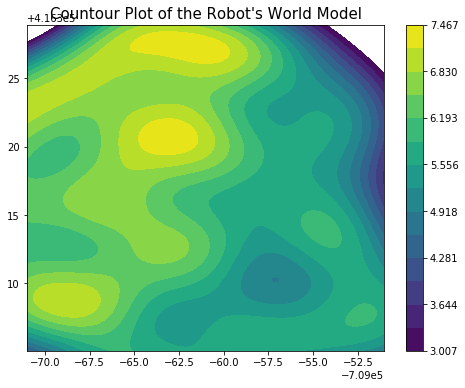

In [18]:
fh_d = fh_df.loc[fh_df['p'].drop_duplicates(subset=['Longitude']).dropna().index]
fh_d = fh_d.loc[fh_d['gga'].dropna(subset=['CO2_ppm_adjusted']).index]
fh_d = fh_d[fh_d['p']['Latitude'] < 41.634]
fh_d = fh_d[fh_d['p']['Latitude'] > 41.6305]
fh_d = fh_d[fh_d['p']['Longitude'] > -70.9071]
fh_d = fh_d[fh_d['ctd']['Depth'] > 0.2]
fh_d = fh_d[fh_d['ctd']['Depth'] < 0.5]
fh_d = fh_d[fh_d['gga']['CH4_ppm_adjusted'] < 8.5]


# ctd_fh = ctd_df.drop(ctd_df[ctd_df.Julian_Date > (0.205+2458207)].index)
# ctd_nb = ctd_df.drop(ctd_df[ctd_df.Julian_Date < (0.231+2458207)].index)
# fh_d = fh_d.dropna()

xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

# plt.scatter(xv*100, yv*100)

ranges = [min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000]

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape

kern = GPy.kern.RBF(input_dim = 2, lengthscale=0.001, variance=np.var(z))
mod = GPy.models.GPRegression(xvals, zvals, kern)
mod.initialize_parameter()
mod.optimize_restarts(num_restarts = 2, messages = True)
print kern

xc = np.linspace(ranges[0], ranges[1], 100)
yc = np.linspace(ranges[2], ranges[3], 100)
xc, yc = np.meshgrid(xc, yc, sparse = False, indexing= 'xy')
data = np.vstack([xc.ravel(), yc.ravel()]).T
obs, var = mod.predict(data, full_cov=False, include_likelihood=True)

fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.set_xlim(ranges[0:2])
ax2.set_ylim(ranges[2:])       
ax2.set_title('Countour Plot of the Robot\'s World Model')     
plot = ax2.contourf(xc, yc, obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
# ax2.scatter(xc, yc, c=obs.reshape(xc.shape), cmap = 'viridis', levels=np.linspace(min(z), max(z), 15), vmin=min(z), vmax=max(z))
ax2.scatter(xv, yv, c=z, cmap='viridis', vmin=min(z), vmax=max(z))
ax2.plot(-70.90668, 41.63118, 'r*', markersize=10)
cbar = fig2.colorbar(plot)

(1458, 2) (1458, 1)
19.965 23.853
6.370657765702211 0.3330176189875886
World max value 7.467374396955659 at location [-709064.919  416322.422]
(-709061.0165000001, 416316.99750000006, 0)
[ 0 ] Current Location:   (-709061.0165000001, 416316.99750000006, 0)
Number of rollouts: 4411 	 Size of tree: 16888
Current predicted max and value: 	[[0. 0.]] 	0.0
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   2.589988e+01   3.058023e+02 
    00s01  0005   9.029452e+00   7.436244e+00 
    00s03  0010   3.930895e+00   1.952556e-02 
    00s04  0016   3.224412e+00   4.479702e-06 
    00s05  0019   3.220132e+00   1.557755e-10 
    00s06  0021   3.220131e+00   6.396929e-14 
Runtime:     00s06
Optimization status: Converged

Optimization restart 1/2, f = 3.22013131166
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   4.896575e+00   1.884382e-01 

Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   2.987034e+00   2.636448e-02 
    00s02  0008   4.017133e+00   4.339322e-01 
    00s04  0013   2.759244e+00   1.263164e-07 
    00s05  0016   2.759244e+00   4.794829e-12 
Runtime:     00s05
Optimization status: Converged

Optimization restart 1/2, f = 2.75924370196
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0007   4.950840e+00   2.004376e-01 
    00s03  0012   2.863893e+00   1.115809e-03 
    00s05  0020   2.759244e+00   9.808355e-11 
Runtime:     00s05
Optimization status: Converged

Optimization restart 2/2, f = 2.75924370255
[ 9 ] Current Location:   (-709065.1350738488, 416314.1541642363, -14.718421052631577)
Number of rollouts: 905 	 Size of tree: 3136
Current predicted max and value: 	[-709066.17986207  416316.58624138] 	4.03874503590139
Optimizing kernel parameters given da

Number of rollouts: 905 	 Size of tree: 3142
Current predicted max and value: 	[-709066.17986207  416316.58624138] 	6.215242849004761
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   6.112427e+00   1.236218e-04 
    00s04  0016   5.008868e+00   4.093052e+01 
    00s13  0047   6.664796e+00   2.747421e-01 
    00s21  0077   2.695800e+00   6.847320e+03 
Runtime:     00s21
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH

Optimization restart 1/2, f = 3.75842132589
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   1.163801e+03   6.847320e+03 
    00s00  0002   5.041452e+02   1.505651e+05 
    00s01  0005   7.290812e+01   1.960925e+03 
    00s03  0012   7.525344e+00   3.189577e-01 
    00s06  0023   6.086411e+00   4.895119e-04 
    00s18  0066   2.633784e+00   5.088312e+05 
    00s19  0072   2.274195e+00   1.309922e+06 
    

    00s05  0018   5.868092e+00   7.958074e-11 
    00s05  0019   5.868092e+00   7.958074e-11 
Runtime:     00s05
Optimization status: Converged

Optimization restart 2/2, f = 5.86809187068
[ 24 ] Current Location:   (-709063.7566487005, 416317.1563490873, -14.59473684210526)
Number of rollouts: 938 	 Size of tree: 3247
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	6.798644481443221
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0002   1.056145e+01   3.581282e+02 
    00s02  0008   4.794377e+00   4.361591e-04 
    00s03  0011   4.794334e+00   5.698865e-14 
Runtime:     00s03
Optimization status: Converged

Optimization restart 1/2, f = 4.79433383241
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005   1.097819e+01   4.224619e+01 
    00s02  0010   4.797440e+00   1.355122e-02 
    00s03  0014   4.794334e+00   6.5

Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0006  -2.186619e+01   5.948555e-03 
    00s05  0018  -2.186620e+01   6.030043e-03 
Runtime:     00s05
Optimization status: Converged

Optimization restart 1/2, f = -21.866195687
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0008  -1.940721e+01   2.321635e+00 
    00s04  0014  -2.173431e+01   7.887792e-06 
    00s09  0032  -2.173431e+01   7.906453e-06 
Runtime:     00s09
Optimization status: Converged

Optimization restart 2/2, f = -21.7343102115
[ 33 ] Current Location:   (-709063.3429714852, 416312.9431214554, -8.286842105263153)
Number of rollouts: 925 	 Size of tree: 3374
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.227211379490276
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|      

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0007  -3.083754e+01   2.015652e+01 
    00s02  0010  -2.903726e+01   2.017483e+04 
    00s05  0019  -3.301213e+01   2.608664e-12 
Runtime:     00s05
Optimization status: Converged

Optimization restart 2/2, f = -33.012130382
[ 41 ] Current Location:   (-709063.0162385284, 416318.78267482703, -23.87105263157894)
few paths available!
Number of rollouts: 873 	 Size of tree: 3093
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.842596639783982
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0007  -3.880840e+01   1.453417e+02 
    00s07  0022  -4.043427e+01   1.212908e+02 
    00s13  0041  -4.203981e+01   3.772058e+03 
Runtime:     00s13
Optimization status: Converged

Optimization restart 1/2, f = -42.0398077819
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i 

    00s02  0009   1.558182e+02   4.538665e+02 
    00s06  0020  -3.648815e+01   7.986226e+01 
    00s19  0057  -5.130621e+01   1.208206e-01 
    00s22  0068  -5.130621e+01   1.208206e-01 
Runtime:     00s22
Optimization status: Converged

Optimization restart 2/2, f = -51.3062097983
[ 49 ] Current Location:   (-709065.0371835915, 416318.81163166533, -9.52368421052631)
Number of rollouts: 863 	 Size of tree: 3106
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.218315206997358
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0005  -6.363354e+01   8.059343e-01 
    00s05  0018  -6.363354e+01   8.059342e-01 
    00s07  0022  -6.363354e+01   8.059343e-01 
Runtime:     00s07
Optimization status: Converged

Optimization restart 1/2, f = -63.6335448634
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001   4.285099e+03   2

Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.226340349149649
Optimizing kernel parameters given data
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0001  -7.301824e+01   4.915699e+01 
    00s02  0008  -7.550028e+01   6.736831e+00 
    00s08  0025  -7.552569e+01   4.504066e+00 
    00s19  0059  -7.552646e+01   4.217129e+00 
    00s23  0084  -7.552646e+01   4.217129e+00 
Runtime:     00s23
Optimization status: ErrorABNORMAL_TERMINATION_IN_LNSRCH

Optimization restart 1/2, f = -75.5264602329
Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s02  0007  -6.594501e+01   3.266015e+02    00s01  0003   5.719858e+02   1.640135e+05 
    00s08  0023  -8.020174e+01   1.440949e+02 
    00s12  0035  -8.044174e+01   1.484283e+03 
    00s19  0059  -8.059700e+01   6.072105e+04 
    00s46  0236  -8.384791e+01   4.961952e+06 
Runtime:     00s46
Optimization status: Converged


Number of rollouts: 832 	 Size of tree: 2947
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.204324112078897
[ 91 ] Current Location:   (-709064.6054333566, 416319.3737191128, -23.871052631578934)
Number of rollouts: 829 	 Size of tree: 2898
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.203363348848016
[ 92 ] Current Location:   (-709063.2134877691, 416316.71618501487, -26.221052631578935)
Number of rollouts: 831 	 Size of tree: 2905
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.203403255923544
[ 93 ] Current Location:   (-709066.1548629599, 416316.1260053921, -28.07631578947367)
Number of rollouts: 758 	 Size of tree: 2732
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.203431281364968
[ 94 ] Current Location:   (-709064.5078172246, 416318.63344239944, -30.426315789473673)
Number of rollouts: 817 	 Size of tree: 2864
Current predicted max and value: 	[-709063.42606897  416320.698827

Number of rollouts: 753 	 Size of tree: 2652
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.208592624283136
[ 128 ] Current Location:   (-709065.0060263203, 416315.2809534213, -22.015789473684194)
Number of rollouts: 732 	 Size of tree: 2583
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.20858840555817
[ 129 ] Current Location:   (-709062.8459383551, 416317.3627843421, -24.365789473684195)
Number of rollouts: 752 	 Size of tree: 2847
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.208599025769399
[ 130 ] Current Location:   (-709065.8450276403, 416317.43669955735, -22.015789473684194)
Number of rollouts: 751 	 Size of tree: 2633
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.20857853947526
[ 131 ] Current Location:   (-709063.6849396751, 416319.5185304781, -24.365789473684195)
Number of rollouts: 741 	 Size of tree: 2656
Current predicted max and value: 	[-709063.42606897  416320.6988

Number of rollouts: 702 	 Size of tree: 2515
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.221242633171556
[ 165 ] Current Location:   (-709065.8248859867, 416318.44497332606, -23.37631578947366)
Number of rollouts: 688 	 Size of tree: 2440
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.221269504923871
[ 166 ] Current Location:   (-709062.8395274037, 416318.148942702, -25.231578947368398)
Number of rollouts: 602 	 Size of tree: 2202
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.221353044443059
[ 167 ] Current Location:   (-709064.608592614, 416315.72605015757, -27.334210526315765)
Number of rollouts: 718 	 Size of tree: 2612
Current predicted max and value: 	[-709063.42606897  416320.69882759] 	7.2214523819360394
[ 168 ] Current Location:   (-709065.0892708391, 416318.6872911886, -29.684210526315766)
Number of rollouts: 708 	 Size of tree: 2498
Current predicted max and value: 	[-709063.42606897  416320.698

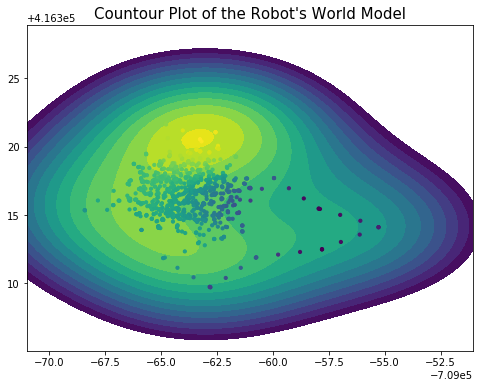

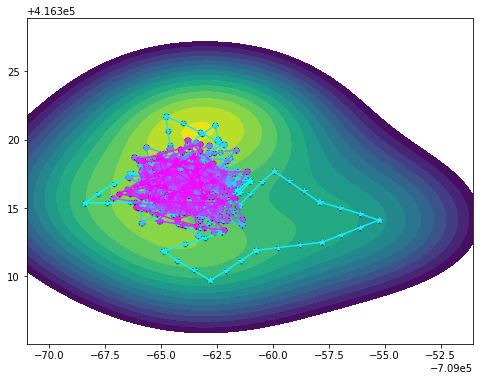

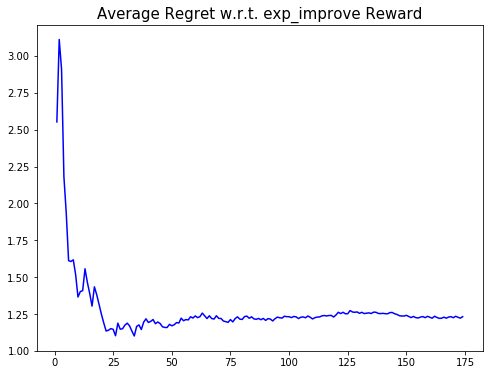

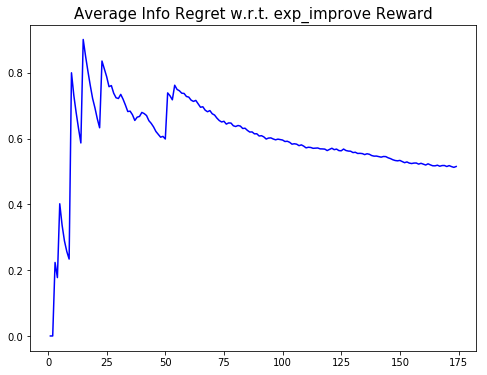

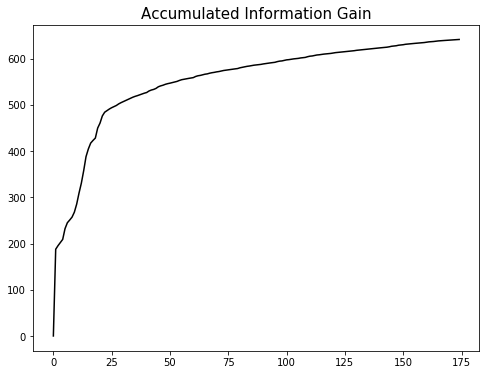

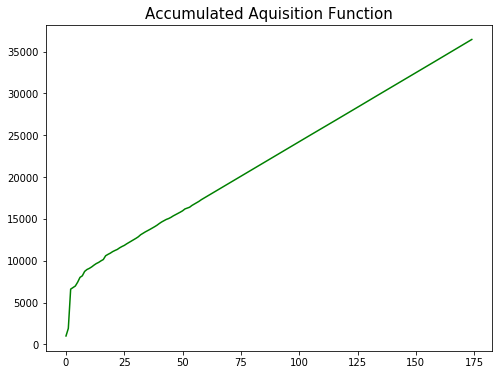

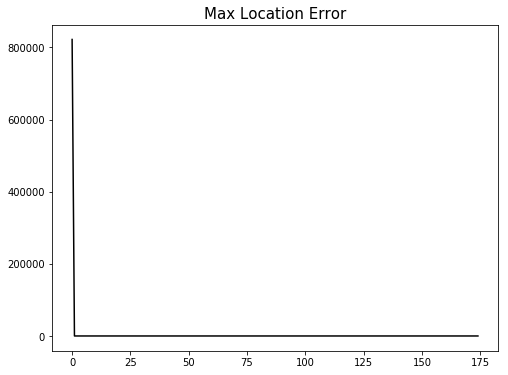

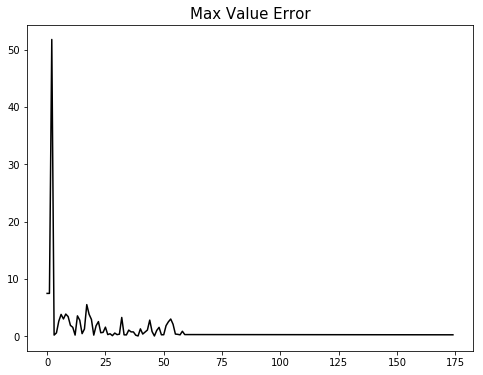

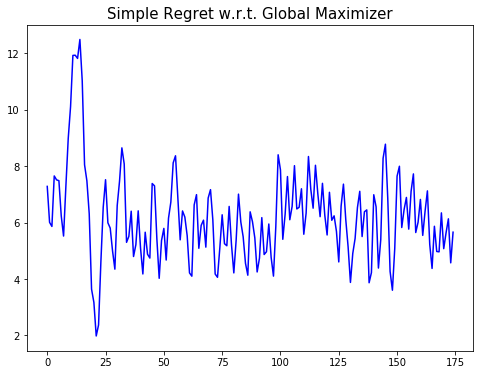

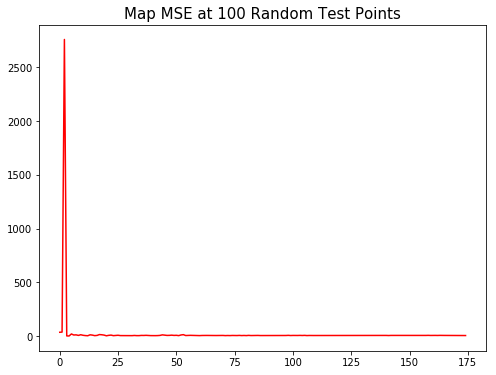

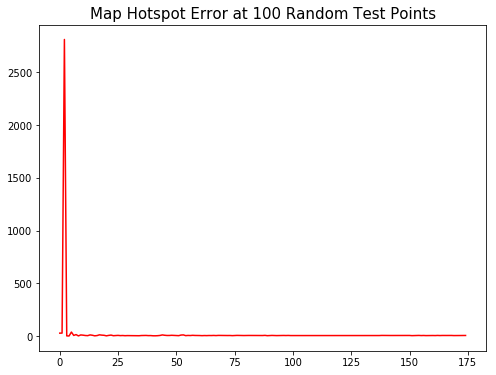

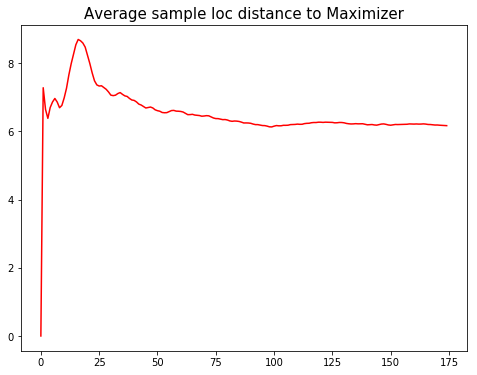

In [33]:
reload(ipp_library)
from ipp_library import *

# Create a random enviroment sampled from a GP with an RBF kernel and specified hyperparameters, mean function 0 
# The enviorment will be constrained by a set of uniformly distributed  sample points of size NUM_PTS x NUM_PTS
''' Options include mean, info_gain, hotspot_info, and mes'''
xv = fh_d['p']['Longitude'][:]
yv = fh_d['p']['Latitude'][:]
z = fh_d['gga']['CH4_ppm_adjusted'][:]

LENGTH = 0.001
VAR = np.var(z)

# plt.scatter(xv*100, yv*100)

points = []
for x,y in zip(xv, yv):
    points.append([x*10000,y*10000])

xvals = np.array(points)
zvals = np.reshape(np.array(z), (len(z), 1))
print xvals.shape, zvals.shape
print max(xv)*10000 - min(xv)*10000, max(yv)*10000 - min(yv)*10000
print np.mean(zvals), np.var(zvals)

ranges = (min(xv)*10000, max(xv)*10000, min(yv)*10000, max(yv)*10000)

reward_function = 'exp_improve'
gp_world = GPModel(ranges, 4.10, 12.93)
gp_world.add_data(xvals, zvals)

world = Environment(ranges = ranges, # x1min, x1max, x2min, x2max constraints
                    NUM_PTS = 20, 
                    variance = 12.93, 
                    lengthscale = 4.10, 
                    visualize = True,
                    seed = None,
                    model = gp_world)

evaluation = Evaluation(world = world, reward_function = reward_function)

# Gather some prior observations to train the kernel (optional)
x1observe = np.linspace(-709070.99900000007, -709051.0340000001, 20)
x2observe = np.linspace(416305.07100000005, 416328.92400000006, 20)
x1observe, x2observe = np.meshgrid(x1observe, x2observe, sparse = False, indexing = 'xy')  
data = np.vstack([x1observe.ravel(), x2observe.ravel()]).T
observations = world.sample_value(data)

print ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0)

# Create the point robot
#obot.__class__ = Nonmyopic_Robot
robot = Nonmyopic_Robot(sample_world = world.sample_value, 
              start_loc = ((min(xv)*10000+max(xv)*10000)/2, (min(yv)*10000+max(yv)*10000)/2, 0), 
              extent = ranges,
              kernel_file = None,
              kernel_dataset = None,
              prior_dataset =  None, 
              #prior_dataset =  (data, observations), 
              init_lengthscale = LENGTH, 
              init_variance = VAR, 
              noise = 0.0001,
              path_generator = 'dubins',
              frontier_size = 20, 
              horizon_length = 3.0, 
              turning_radius = 0.05,
              sample_step = 1.0,
              evaluation = evaluation, 
              f_rew = reward_function, 
              create_animation = True,
              computation_budget = 10.0,
              rollout_length = 5) 

robot.planner(T = 175)
robot.visualize_world_model(screen = True)
robot.visualize_trajectory(screen = True)
robot.plot_information()
